In [1]:
import tensorflow as tf
from PIL import Image

In [2]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
%matplotlib inline

In [3]:
import numpy as np

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
img_size=400
vgg=tf.keras.applications.VGG19(include_top=False,input_shape=[img_size,img_size,3],
                                weights='/content/drive/MyDrive/vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5')

(1, 400, 400, 3)


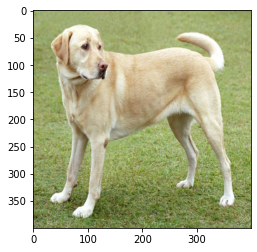

In [6]:
content_image=np.array(Image.open("/content/drive/MyDrive/content.jpg").resize((img_size,img_size)))
content_image = tf.constant(np.reshape(content_image, ((1,) + content_image.shape)))

print(content_image.shape)
imshow(content_image[0])
plt.show()

(1, 400, 400, 3)


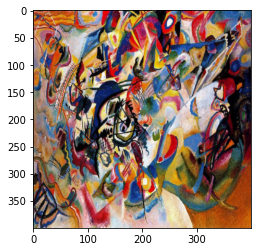

In [7]:
style_image=np.array(Image.open("/content/drive/MyDrive/style.jpg").resize((img_size,img_size)))
style_image=tf.constant(style_image,shape=(1,)+style_image.shape)

print(style_image.shape)
imshow(style_image[0])
plt.show()

In [8]:
for layers in vgg.layers:
  print(layers.name)

input_1
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


In [9]:
STYLE_LAYERS=[
              ('block1_conv1',0.2),
              ('block2_conv1',0.2),
              ('block3_conv1',0.2),
              ('block4_conv1',0.2),
              ('block5_conv1',0.2)
]

In [10]:
CONTENT_LAYER=[('block5_conv4',1)]

In [11]:
def get_layer_outputs(vgg,layers):
  output=[vgg.get_layer(layer[0]).output for layer in layers]

  model=tf.keras.Model([vgg.input],output)

  return model

In [12]:
vgg_layer_outputs=get_layer_outputs(vgg,STYLE_LAYERS+CONTENT_LAYER)

In [13]:
# content_value=vgg_layer_outputs(content_image)
preprocessed_content=tf.Variable(tf.image.convert_image_dtype(content_image,dtype=tf.float32))
preprocessed_content=vgg_layer_outputs(preprocessed_content)

In [14]:
# content_value=vgg_layer_outputs(content_image)
preprocessed_style=tf.Variable(tf.image.convert_image_dtype(style_image,dtype=tf.float32))
preprocessed_style=vgg_layer_outputs(preprocessed_style)

In [15]:
def compute_content_cost(content_output,generated_output):

  a_C=content_output[-1]
  a_G=generated_output[-1]


  m,n_H,n_W,n_C=a_C.shape
  a_C=tf.reshape(a_C,shape=[m,-1,n_C])
  a_G=tf.reshape(a_G,shape=[m,-1,n_C])

  J_content=tf.reduce_sum(tf.square(tf.subtract(a_C,a_G)))/(4*n_H*n_W*n_C)

  return J_content

In [16]:
def gram_matrix(A):

  return tf.matmul(A,tf.transpose(A))

In [17]:
def style_layer_cost(a_S,a_G):
  m,n_H,n_W,n_C=a_S.shape

  a_S = tf.transpose(tf.reshape(a_S,[-1,n_C]))
  a_G = tf.transpose(tf.reshape(a_G,[-1,n_C]))

  Ga_S=gram_matrix(a_S)
  Ga_G=gram_matrix(a_G)

  J_style=tf.reduce_sum(tf.square(tf.subtract(Ga_S,Ga_G)))/(4*n_H*n_H*n_W*n_W*n_C*n_C)

  return J_style

In [18]:
def compute_style_cost(style_output,generated_output,STYLE_LAYERS=STYLE_LAYERS):

  a_S=style_output[:-1]
  a_G=generated_output[:-1]

  l=len(a_S)

  J_STYLE=0

  for i,w in zip(range(l),STYLE_LAYERS):

    J_STYLE+=w[1]*style_layer_cost(a_S[i],a_G[i])
  return J_STYLE

In [19]:
def total_cost(content_cost,style_cost,alpha=10,beta=40):

  return (content_cost*alpha+style_cost*beta)

In [20]:
def clip_0_1(generated_image):
  return tf.clip_by_value(generated_image,clip_value_min=0,clip_value_max=1)


def tensor_to_image(tensor):
  tensor=tensor*255
  tensor=np.array(tensor,dtype=np.uint8)

  if np.ndim(tensor) > 3:
        assert tensor.shape[0] == 1
        tensor = tensor[0]
  return Image.fromarray(tensor)

In [21]:
optimizer=tf.keras.optimizers.Adam(learning_rate=0.03)
@tf.function()
def tarin_step(generated_image):
  with tf.GradientTape() as tape:

    a_G=vgg_layer_outputs(generated_image)

    content_cost=compute_content_cost(preprocessed_content,a_G)

    style_cost=compute_style_cost(preprocessed_style,a_G)

    J=total_cost(content_cost,style_cost)
  grad=tape.gradient(J,generated_image)
  optimizer.apply_gradients([(grad,generated_image)])
  generated_image.assign(clip_0_1(generated_image))

  return J

In [22]:
generated_image = tf.Variable(tf.image.convert_image_dtype(content_image, tf.float32))


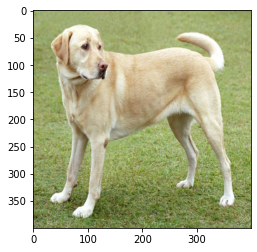

In [23]:
image = tensor_to_image(generated_image)
imshow(image)
plt.show()

Epoch 0 


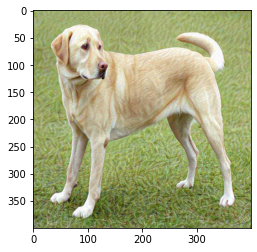

Epoch 250 


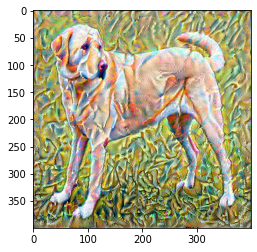

Epoch 500 


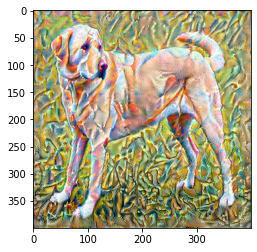

Epoch 750 


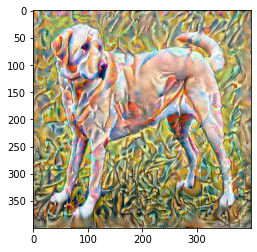

Epoch 1000 


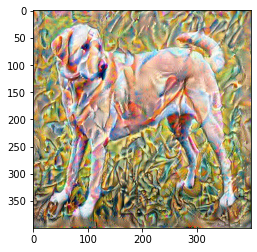

Epoch 1250 


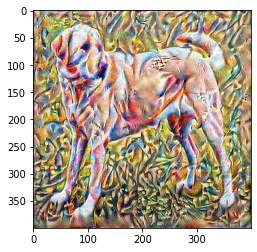

Epoch 1500 


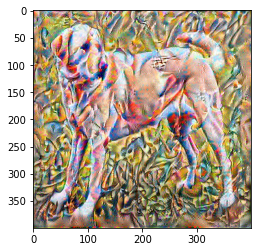

Epoch 1750 


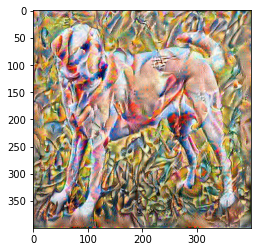

Epoch 2000 


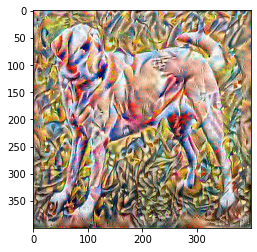

Epoch 2250 


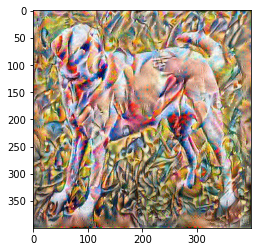

Epoch 2500 


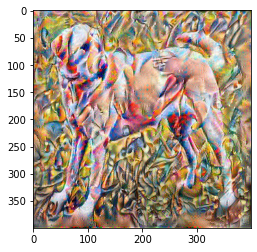

Epoch 2750 


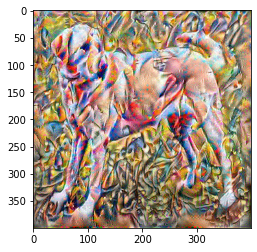

Epoch 3000 


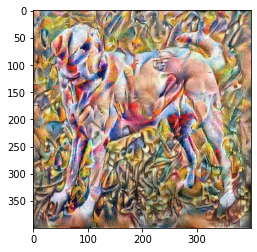

Epoch 3250 


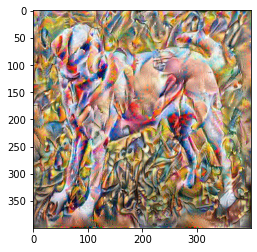

Epoch 3500 


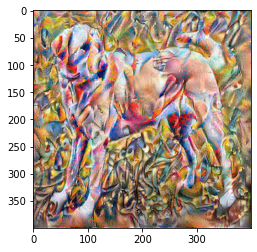

Epoch 3750 


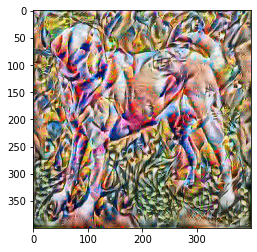

Epoch 4000 


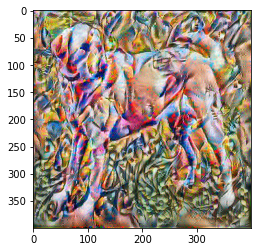

Epoch 4250 


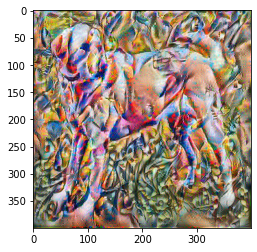

Epoch 4500 


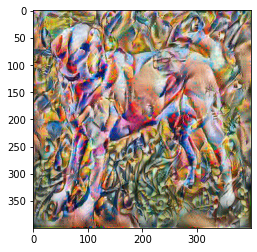

Epoch 4750 


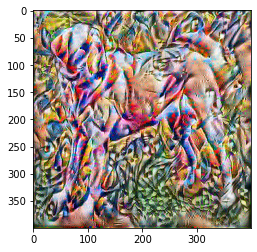

In [24]:
epoch_num=5000

for i in range(epoch_num):
  tarin_step(generated_image)
  if i % 250 == 0:
        print(f"Epoch {i} ")
  if i % 250 == 0:
        image = tensor_to_image(generated_image)
        imshow(image)
        image.save(f"/content/drive/MyDrive/CP/image/image_p12_{i}.jpg")
        plt.show()